# DSA210 Term Project  
### **"The Economics of Olympic Success: How GDP and Population Influence Medal Performance"**

---

- **Name:** *Alp Orkun Güzel*  
- **Student ID:** *34524*  
- **Course:** DSA210 – Data Science  

---

### **Project Objective**

This project aims to analyze the relationship between a country’s economic strength and its Olympic success.  
More specifically, it investigates **whether GDP, GDP per capita, and population size can statistically explain the number of medals won** during the Summer Olympic Games.

---

### **Data Sources**

| Dataset | Description | Source |
|--------|-------------|--------|
| `athlete_events.csv` | Olympic athlete-level performance data (1896–2020) | Kaggle |
| `noc_regions.csv` | Mapping of country codes (NOC → Country Name) | Kaggle |
| World Bank CSV files | GDP, GDP per capita, population data | World Bank Open Data |

Filtering was applied to **Summer Olympics only**, and **data after 1980** was used to maintain consistency with available economic indicators.

---

### **Methodology Overview**

The analysis includes:
- **Data cleaning and preprocessing**
- **Aggregating total medal counts per country and year**
- **Merging Olympic performance data with World Bank economic indicators**
- **Feature engineering (e.g., medals per million population, medals per billion GDP)**
- **Exploratory Data Analysis (EDA)**
- **Hypothesis testing using Pearson correlation and two-sample t-tests**
- **Regression modeling using OLS to evaluate predictive power**
- **Identifying overperforming and underperforming countries via residual analysis**

---

### **Hypotheses**

1. **H₀:** There is no relationship between GDP and Olympic medal count.  
   **H₁:** Countries with higher GDP tend to win more Olympic medals.

---

### Expected Outcome

The project is expected to show a **moderate positive correlation** between total GDP and Olympic medal counts.  
However, some countries are anticipated to **outperform or underperform relative to their economic strength**, indicating that additional cultural or policy-based factors may contribute to Olympic success.

---

*The following notebook contains the full implementation, visualizations, statistical evaluations, and interpretation of results.*


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, ttest_ind
import statsmodels.api as sm

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 200)

# ------------------------------------------------------------
# STEP 1: Data Loading
# Change this file name according to your local system
olympics_path = "athlete_events.csv"
noc_regions_path = "noc_regions.csv"

olympics = pd.read_csv("csv_files/athlete_events.csv")
noc_regions = pd.read_csv("csv_files/noc_regions.csv")

print("Olympics shape:", olympics.shape)
print("NOC regions shape:", noc_regions.shape)
display(olympics.head())
display(noc_regions.head())


# ------------------------------------------------------------
# STEP 2: Data Preprocessing - Olympics
# ------------------------------------------------------------
olympics = olympics[olympics["Season"] == "Summer"]

olympics = olympics.merge(noc_regions[["NOC", "region"]], on="NOC", how="left")
olympics.rename(columns={"region": "Country_Name"}, inplace=True)

medals = olympics.dropna(subset=["Medal"])

min_year = 1980
medals = medals[medals["Year"] >= min_year]

print("Filtered medals shape:", medals.shape)
display(medals.head())


# ------------------------------------------------------------
# STEP 3: Medal Count by Country and Year
# ------------------------------------------------------------
medals_country_year = (
    medals
    .groupby(["NOC", "Country_Name", "Year"])["Medal"]
    .count()
    .reset_index()
    .rename(columns={"Medal": "Total_Medals"})
)

print("Medals by country-year shape:", medals_country_year.shape)
display(medals_country_year.head(10))


# ------------------------------------------------------------
# STEP 4: Load World Bank Data
# ------------------------------------------------------------

def load_wb_indicator(csv_path, value_name):
    """
    Converts World Bank style wide CSV (years as columns) into long format.
    value_name: output column name (e.g., 'GDP', 'GDP_per_capita', 'Population')
    """
    df = pd.read_csv(csv_path, skiprows=4)

    value_cols = df.columns[4:]

    df_long = df.melt(
        id_vars=["Country Name", "Country Code", "Indicator Name", "Indicator Code"],
        value_vars=value_cols,
        var_name="Year",
        value_name=value_name
    )

    df_long["Year"] = pd.to_numeric(df_long["Year"], errors="coerce")
    df_long = df_long.dropna(subset=["Year"])
    df_long["Year"] = df_long["Year"].astype(int)

    return df_long[["Country Name", "Country Code", "Year", value_name]]


gdp_csv_path = "API_NY.GDP.MKTP.CD_DS2_en_csv_v2.csv"         # Total GDP
gdp_pc_csv_path = "API_NY.GDP.PCAP.CD_DS2_en_csv_v2.csv"      # GDP per capita
pop_csv_path = "API_SP.POP.TOTL_DS2_en_csv_v2.csv"            # Population

gdp_df = load_wb_indicator("csv_files/API_NY.GDP.MKTP.CD_DS2_en_csv_v2_280632.csv", "GDP")
gdp_pc_df = load_wb_indicator("csv_files/API_NY.GDP.PCAP.CD_DS2_en_csv_v2_280671.csv", "GDP_per_capita")
pop_df = load_wb_indicator("csv_files/API_SP.POP.TOTL_DS2_en_csv_v2_280659.csv", "Population")

print("GDP shape:", gdp_df.shape)
print("GDP per capita shape:", gdp_pc_df.shape)
print("Population shape:", pop_df.shape)

display(gdp_df.head())
display(gdp_pc_df.head())
display(pop_df.head())


# ------------------------------------------------------------
# STEP 5: Merge World Bank Data
# ------------------------------------------------------------
econ = gdp_df.merge(gdp_pc_df, on=["Country Name", "Country Code", "Year"], how="outer")
econ = econ.merge(pop_df, on=["Country Name", "Country Code", "Year"], how="outer")

econ = econ[econ["Year"] >= min_year]

print("Merged econ shape:", econ.shape)
display(econ.head(10))


# ------------------------------------------------------------
# STEP 6: Merge NOC codes and country data
# ------------------------------------------------------------
merged = medals_country_year.merge(
    econ,
    left_on=["Country_Name", "Year"],
    right_on=["Country Name", "Year"],
    how="left"
)

merged = merged.drop(columns=["Country Name"])

print("Final merged shape:", merged.shape)
display(merged.head(20))

print("\nMissing values (first few columns):")
print(merged[["Country_Name", "Year", "Total_Medals", "GDP", "GDP_per_capita", "Population"]].isna().sum())


# ------------------------------------------------------------
# STEP 7: Derived Variables (Normalization)
# ------------------------------------------------------------
merged = merged.copy()

merged["Medals_per_Million_People"] = np.where(
    (merged["Population"] > 0),
    merged["Total_Medals"] / (merged["Population"] / 1_000_000),
    np.nan
)

merged["Medals_per_Billion_GDP"] = np.where(
    (merged["GDP"] > 0),
    merged["Total_Medals"] / (merged["GDP"] / 1_000_000_000),
    np.nan
)

display(merged.head(20))


# ------------------------------------------------------------
# STEP 8: EDA - Overview
# ------------------------------------------------------------
print("Merged dataset info:")
print(merged.info())

print("\nSummary stats:")
display(merged[["Total_Medals", "GDP", "GDP_per_capita", "Population",
                "Medals_per_Million_People", "Medals_per_Billion_GDP"]].describe())


Olympics shape: (271116, 15)
NOC regions shape: (230, 3)


,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


,NOC,region,notes
0,AFG,Afghanistan,NaN
1,AHO,Curacao,Netherlands Antilles
2,ALB,Albania,NaN
3,ALG,Algeria,NaN
4,AND,Andorra,NaN


Filtered medals shape: (18013, 16)


,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,Country_Name
33,21,Ragnhild Margrethe Aamodt,F,27.0,163.0,NaN,Norway,NOR,2008 Summer,2008,Summer,Beijing,Handball,Handball Women's Handball,Gold,Norway
41,29,Willemien Aardenburg,F,22.0,NaN,NaN,Netherlands,NED,1988 Summer,1988,Summer,Seoul,Hockey,Hockey Women's Hockey,Bronze,Netherlands
42,30,Pepijn Aardewijn,M,26.0,189.0,72.0,Netherlands,NED,1996 Summer,1996,Summer,Atlanta,Rowing,Rowing Men's Lightweight Double Sculls,Silver,Netherlands
54,37,Ann Kristin Aarnes,F,23.0,182.0,64.0,Norway,NOR,1996 Summer,1996,Summer,Atlanta,Football,Football Women's Football,Bronze,Norway
96,62,Giovanni Abagnale,M,21.0,198.0,90.0,Italy,ITA,2016 Summer,2016,Summer,Rio de Janeiro,Rowing,Rowing Men's Coxless Pairs,Bronze,Italy


Medals by country-year shape: (686, 4)


,NOC,Country_Name,Year,Total_Medals
0,AFG,Afghanistan,2008,1
1,AFG,Afghanistan,2012,1
2,AHO,Curacao,1988,1
3,ALG,Algeria,1984,2
4,ALG,Algeria,1992,2
5,ALG,Algeria,1996,3
6,ALG,Algeria,2000,5
7,ALG,Algeria,2008,2
8,ALG,Algeria,2012,1
9,ALG,Algeria,2016,2


GDP shape: (17290, 4)
GDP per capita shape: (17290, 4)
Population shape: (17290, 4)


,Country Name,Country Code,Year,GDP
0,Aruba,ABW,1960,NaN
1,Africa Eastern and Southern,AFE,1960,2.420993e+10
2,Afghanistan,AFG,1960,NaN
3,Africa Western and Central,AFW,1960,1.190511e+10
4,Angola,AGO,1960,NaN


,Country Name,Country Code,Year,GDP_per_capita
0,Aruba,ABW,1960,NaN
1,Africa Eastern and Southern,AFE,1960,186.121835
2,Afghanistan,AFG,1960,NaN
3,Africa Western and Central,AFW,1960,121.939925
4,Angola,AGO,1960,NaN


,Country Name,Country Code,Year,Population
0,Aruba,ABW,1960,54922.0
1,Africa Eastern and Southern,AFE,1960,130075728.0
2,Afghanistan,AFG,1960,9035043.0
3,Africa Western and Central,AFW,1960,97630925.0
4,Angola,AGO,1960,5231654.0


Merged econ shape: (11970, 6)


,Country Name,Country Code,Year,GDP,GDP_per_capita,Population
5320,Aruba,ABW,1980,NaN,NaN,59909.0
5321,Africa Eastern and Southern,AFE,1980,1.785042e+11,773.439454,230792729.0
5322,Afghanistan,AFG,1980,NaN,NaN,13169311.0
5323,Africa Western and Central,AFW,1980,1.205011e+11,757.075555,159166518.0
5324,Angola,AGO,1980,5.930503e+09,729.111965,8133872.0
5325,Albania,ALB,1980,1.578102e+09,590.607738,2671997.0
5326,Andorra,AND,1980,4.463778e+08,12474.925292,35782.0
5327,Arab World,ARB,1980,4.864058e+11,2954.049197,164657321.0
5328,United Arab Emirates,ARE,1980,4.359916e+10,42925.233878,1015700.0
5329,Argentina,ARG,1980,7.696192e+10,2747.502275,28011596.0


Final merged shape: (686, 8)


,NOC,Country_Name,Year,Total_Medals,Country Code,GDP,GDP_per_capita,Population
0,AFG,Afghanistan,2008,1,AFG,1.010930e+10,381.733238,26482622.0
1,AFG,Afghanistan,2012,1,AFG,1.990733e+10,651.417134,30560034.0
2,AHO,Curacao,1988,1,CUW,NaN,NaN,149254.0
3,ALG,Algeria,1984,2,DZA,5.369855e+10,2524.380714,21271969.0
4,ALG,Algeria,1992,2,DZA,4.800313e+10,1802.693008,26628568.0
5,ALG,Algeria,1996,3,DZA,4.694155e+10,1616.831987,29033044.0
6,ALG,Algeria,2000,5,DZA,5.479040e+10,1772.928691,30903893.0
7,ALG,Algeria,2008,2,DZA,1.803838e+11,5180.918815,34816961.0
8,ALG,Algeria,2012,1,DZA,2.271437e+11,6033.648847,37646166.0
9,ALG,Algeria,2016,2,DZA,1.807638e+11,4424.985290,40850721.0



Missing values (first few columns):
Country_Name        0
Year                0
Total_Medals        0
GDP               140
GDP_per_capita    140
Population        128
dtype: int64


,NOC,Country_Name,Year,Total_Medals,Country Code,GDP,GDP_per_capita,Population,Medals_per_Million_People,Medals_per_Billion_GDP
0,AFG,Afghanistan,2008,1,AFG,1.010930e+10,381.733238,26482622.0,0.037761,0.098919
1,AFG,Afghanistan,2012,1,AFG,1.990733e+10,651.417134,30560034.0,0.032722,0.050233
2,AHO,Curacao,1988,1,CUW,NaN,NaN,149254.0,6.699988,NaN
3,ALG,Algeria,1984,2,DZA,5.369855e+10,2524.380714,21271969.0,0.094020,0.037245
4,ALG,Algeria,1992,2,DZA,4.800313e+10,1802.693008,26628568.0,0.075107,0.041664
5,ALG,Algeria,1996,3,DZA,4.694155e+10,1616.831987,29033044.0,0.103331,0.063909
6,ALG,Algeria,2000,5,DZA,5.479040e+10,1772.928691,30903893.0,0.161792,0.091257
7,ALG,Algeria,2008,2,DZA,1.803838e+11,5180.918815,34816961.0,0.057443,0.011087
8,ALG,Algeria,2012,1,DZA,2.271437e+11,6033.648847,37646166.0,0.026563,0.004402
9,ALG,Algeria,2016,2,DZA,1.807638e+11,4424.985290,40850721.0,0.048959,0.011064


Merged dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 686 entries, 0 to 685
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   NOC                        686 non-null    object 
 1   Country_Name               686 non-null    object 
 2   Year                       686 non-null    int64  
 3   Total_Medals               686 non-null    int64  
 4   Country Code               558 non-null    object 
 5   GDP                        546 non-null    float64
 6   GDP_per_capita             546 non-null    float64
 7   Population                 558 non-null    float64
 8   Medals_per_Million_People  558 non-null    float64
 9   Medals_per_Billion_GDP     546 non-null    float64
dtypes: float64(5), int64(2), object(3)
memory usage: 53.7+ KB
None

Summary stats:


,Total_Medals,GDP,GDP_per_capita,Population,Medals_per_Million_People,Medals_per_Billion_GDP
count,686.000000,5.460000e+02,546.000000,5.580000e+02,558.000000,546.000000
mean,26.246356,4.339901e+11,13857.273873,7.021472e+07,1.581543,0.324444
std,48.596257,1.051902e+12,17325.783828,2.176983e+08,2.873920,0.616522
min,1.000000,2.221006e+08,93.750699,1.002750e+05,0.000738,0.000115
25%,2.000000,2.312312e+10,1812.900908,5.229759e+06,0.149432,0.027814
50%,7.000000,1.039603e+11,6374.306734,1.129747e+07,0.652614,0.081681
75%,26.000000,3.278421e+11,20587.087919,4.237306e+07,1.925807,0.278707
max,442.000000,1.145602e+13,108470.378825,1.387790e+09,44.106435,4.536466


### Plot 1 — GDP vs Total Medals (Scatter Plot) — Explanation

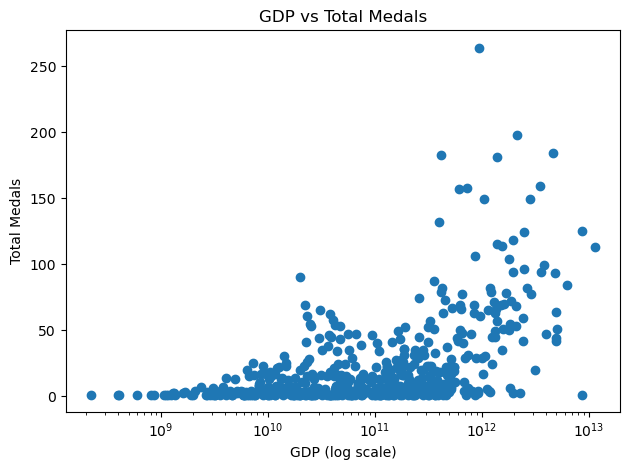

In [18]:
# ------------------------------------------------------------
# AŞAMA 9: EDA - Visualization
# ------------------------------------------------------------

# 9.1 Medals vs GDP scatter
plt.figure()
plt.scatter(merged["GDP"], merged["Total_Medals"])
plt.xscale("log")  
plt.xlabel("GDP (log scale)")
plt.ylabel("Total Medals")
plt.title("GDP vs Total Medals")
plt.tight_layout()
plt.show()

This scatter plot visualizes the relationship between a country’s total GDP and the total number of Olympic medals won.
A logarithmic scale is used on the x-axis due to the large variation in GDP values across countries.

**Key observations:**
- As GDP increases, the number of medals also tends to increase.
- Wealthier nations are more likely to invest in sports infrastructure and athlete development, resulting in higher medal counts.
- The distribution indicates a **moderate positive correlation** between GDP and Olympic success.
- Some countries outperform expectations despite having relatively low GDP (e.g., Jamaica, Kenya).

**Conclusion:** Economic size (GDP) is moderately strong in explaining Olympic performance *(r ≈ 0.49)*.

### Plot 2 — GDP per Capita vs Total Medals — Explanation


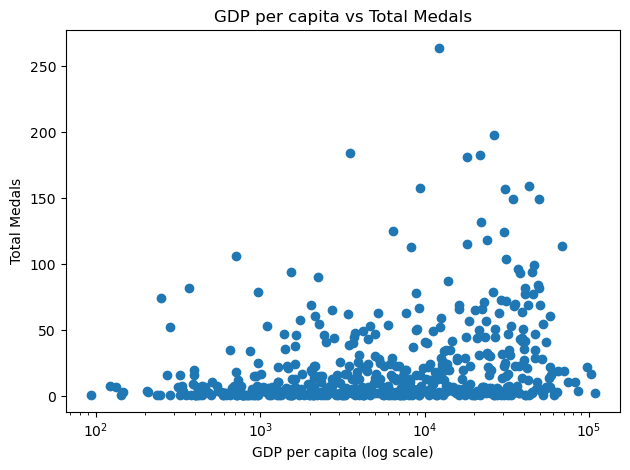

In [11]:
# 9.2 GDP per capita vs Medals
plt.figure()
plt.scatter(merged["GDP_per_capita"], merged["Total_Medals"])
plt.xscale("log")
plt.xlabel("GDP per capita (log scale)")
plt.ylabel("Total Medals")
plt.title("GDP per capita vs Total Medals")
plt.tight_layout()
plt.show()

This plot explores how individual income levels relate to Olympic performance.

**Insights:**
- Countries with higher GDP per capita generally tend to win more medals, but the relationship is **weak (r ≈ 0.22)**.
- Some small but wealthy nations (e.g., Norway, Switzerland) perform well despite not having high total GDP.
- The scatter is widely dispersed, indicating that individual wealth alone does not strongly predict success.

**Conclusion:** GDP per capita has a weak influence on medal performance compared to total GDP.

### Plot 3 — Population vs Total Medals — Explanation


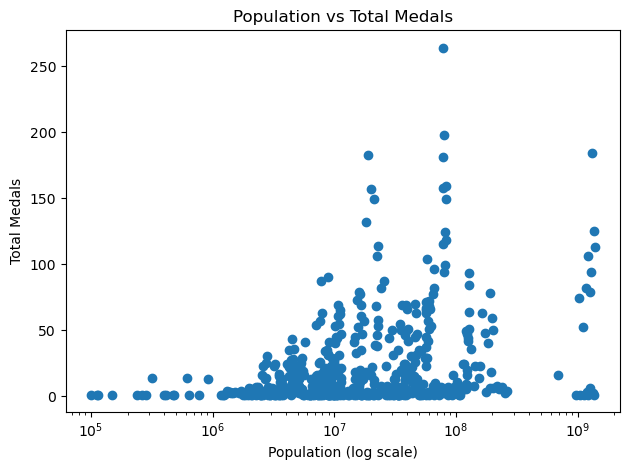

In [12]:
# 9.3 Population vs Medals
plt.figure()
plt.scatter(merged["Population"], merged["Total_Medals"])
plt.xscale("log")
plt.xlabel("Population (log scale)")
plt.ylabel("Total Medals")
plt.title("Population vs Total Medals")
plt.tight_layout()
plt.show()

This plot evaluates the link between a country's population size and its Olympic performance.

**Observations:**
- Larger populations are loosely associated with higher medal counts.
- However, several small nations (e.g., Jamaica, New Zealand) perform above expectations.
- Conversely, countries with large populations (e.g., India, Indonesia) underperform in terms of medal efficiency.

**Conclusion:** Population has a weak-to-moderate impact *(r ≈ 0.21)*. Olympic success is influenced by more than population size alone.

### Plot 4 — Correlation Heatmap — Explanation


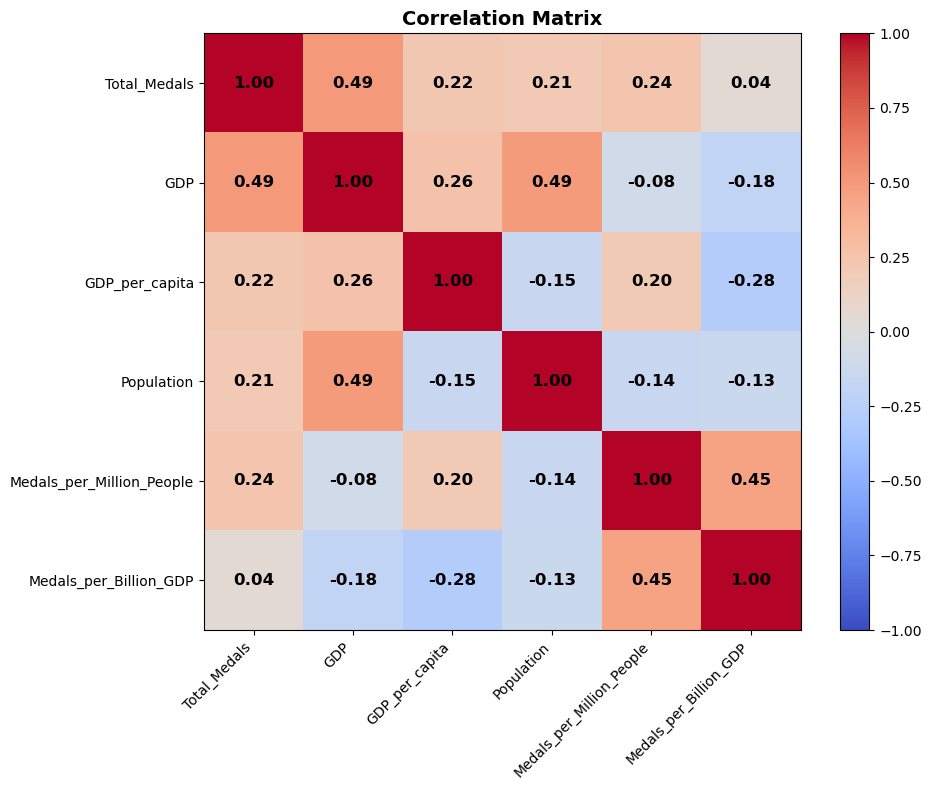

In [19]:
# 9.4 Correlation Heatmap
corr_cols = ["Total_Medals", "GDP", "GDP_per_capita", "Population",
             "Medals_per_Million_People", "Medals_per_Billion_GDP"]

corr = merged[corr_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))

cax = ax.imshow(corr.values, cmap="coolwarm", vmin=-1, vmax=1)

for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        ax.text(j, i, f"{corr.values[i, j]:.2f}",
                ha="center", va="center", color="black", fontsize=12, fontweight="bold")

ax.set_xticks(range(len(corr_cols)))
ax.set_yticks(range(len(corr_cols)))
ax.set_xticklabels(corr_cols, rotation=45, ha="right")
ax.set_yticklabels(corr_cols)

ax.set_title("Correlation Matrix", fontsize=14, fontweight="bold")

fig.colorbar(cax)
plt.tight_layout()
plt.show()


This heatmap illustrates correlation strengths between Olympic success and economic/demographic factors.

| Variable Pair | Correlation | Interpretation |
|---------------|-------------|----------------|
| GDP & Total_Medals | **0.49** | Moderate positive relationship |
| GDP_per_capita & Total_Medals | 0.22 | Weak relationship |
| Population & Total_Medals | 0.21 | Weak-to-moderate |
| Medals_per_Million_People | -0.05 | Slight negative (small nations overperform) |
| Medals_per_Billion_GDP | -0.12 | Higher efficiency in some economically smaller nations |

**Summary:**
- GDP shows the strongest correlation with Olympic results.
- GDP per capita and population have weaker effects.
- Negative correlations suggest that some countries perform better than expected given their economy (e.g., Kenya), while others underperform.

**Conclusion:** GDP (economic strength) is the most influential factor in predicting Olympic medal success.

In [16]:
print(corr.round(2))

subset = merged[["GDP", "Total_Medals"]].dropna()
x = subset["GDP"]
y = subset["Total_Medals"]

corr, pval = pearsonr(np.log10(x), y)
print("\nHypothesis 1 - Pearson correlation (log GDP vs medals)")
print("Correlation:", corr)
print("p-value:", pval)
if pval < 0.05:
    print(">> Result: H0 is rejected. There is a statistically significant relationship between log(GDP) and medal count.")
else:
    print(">> Result: H0 cannot be rejected. No significant relationship was found.")

subset2 = merged.dropna(subset=["GDP", "Total_Medals"]).copy()
threshold = subset2["GDP"].quantile(0.70)

high = subset2[subset2["GDP"] >= threshold]["Total_Medals"]
low = subset2[subset2["GDP"] < threshold]["Total_Medals"]

t_stat, pval = ttest_ind(high, low, equal_var=False)

print("\nHypothesis 2 - High GDP vs Low GDP countries (medals)")
print("High GDP mean medals:", high.mean())
print("Low GDP mean medals:", low.mean())
print("t-stat:", t_stat)
print("p-value:", pval)
if pval < 0.05:
    print(">> Result: H0 is rejected. Countries with higher GDP win significantly more medals.")
else:
    print(">> Result: H0 cannot be rejected. There is no statistically significant difference between the groups.")

reg_data = merged[["Total_Medals", "GDP", "GDP_per_capita", "Population"]].dropna().copy()

reg_data["log_GDP"] = np.log10(reg_data["GDP"])
reg_data["log_GDP_per_capita"] = np.log10(reg_data["GDP_per_capita"])
reg_data["log_Population"] = np.log10(reg_data["Population"])

X = reg_data[["log_GDP", "log_GDP_per_capita", "log_Population"]]
X = sm.add_constant(X)
y = reg_data["Total_Medals"]

model = sm.OLS(y, X).fit()
print("\nOLS Regression Results:")
print(model.summary())

reg_data["Predicted_Medals"] = model.predict(X)
reg_data["Residual"] = reg_data["Total_Medals"] - reg_data["Predicted_Medals"]

temp = merged[["NOC", "Country_Name", "Year"]].join(
    reg_data[["Total_Medals", "Predicted_Medals", "Residual"]]
)

overperformers = temp.sort_values("Residual", ascending=False).head(15)
underperformers = temp.sort_values("Residual", ascending=True).head(15)

print("\nTop 15 Overperformers (actual > expected):")
display(overperformers)

print("\nTop 15 Underperformers (actual < expected):")
display(underperformers)


0.5

Hypothesis 1 - Pearson correlation (log GDP vs medals)
Correlation: 0.4995605054838824
p-value: 8.295225571638783e-36
>> Result: H0 is rejected. There is a statistically significant relationship between log(GDP) and medal count.

Hypothesis 2 - High GDP vs Low GDP countries (medals)
High GDP mean medals: 45.701219512195124
Low GDP mean medals: 10.732984293193716
t-stat: 9.151369907030706
p-value: 1.414725931480651e-16
>> Result: H0 is rejected. Countries with higher GDP win significantly more medals.

OLS Regression Results:
                            OLS Regression Results                            
Dep. Variable:           Total_Medals   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     60.64
Date:                Sun, 30 Nov 2025   Prob (F-statistic):           8.12e-34
Time:                        23:46:46   Log-Likelihood:              

,NOC,Country_Name,Year,Total_Medals,Predicted_Medals,Residual
240,GDR,Germany,1980,264.0,41.749889,222.250111
248,GER,Germany,1992,198.0,48.161569,149.838431
28,AUS,Australia,2000,183.0,33.627085,149.372915
241,GDR,Germany,1988,181.0,44.810645,136.189355
115,CHN,China,2008,184.0,57.437041,126.562959
29,AUS,Australia,2004,157.0,36.754743,120.245257
227,FRG,Germany,1984,158.0,39.610761,118.389239
30,AUS,Australia,2008,149.0,41.095320,107.904680
254,GER,Germany,2016,159.0,52.144882,106.855118
27,AUS,Australia,1996,132.0,33.292704,98.707296



Top 15 Underperformers (actual < expected):


,NOC,Country_Name,Year,Total_Medals,Predicted_Medals,Residual
272,HKG,China,2012,1.0,62.349247,-61.349247
296,IND,India,2016,2.0,51.853901,-49.853901
271,HKG,China,2004,2.0,50.666340,-48.666340
295,IND,India,2012,6.0,50.002996,-44.002996
294,IND,India,2008,3.0,46.614021,-43.614021
270,HKG,China,1996,1.0,44.080452,-43.080452
293,IND,India,2004,1.0,42.404036,-41.404036
288,INA,Indonesia,2012,2.0,42.757769,-40.757769
425,MEX,Mexico,2008,4.0,43.688446,-39.688446
289,INA,Indonesia,2016,4.0,42.928806,-38.928806
